In [1]:
import os
import re
import glob
import bbi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Path, PathPatch, Rectangle
from matplotlib.collections import PatchCollection

In [2]:
def draw_bigwig(ax, bwfile, chrom, start, end, color, bins=100):
    track_patch = list()
    with bbi.open(bwfile) as f:
        data = f.fetch(chrom, start, end, bins)
        minx = np.min(data)
        maxx = np.max(data)
        for i, x in enumerate(data):
            startx = start + i * 50
            track_rect = Rectangle([startx, 0], 50, x, color=color)
            track_patch.append(track_rect)
    track_collection = PatchCollection(track_patch, match_original=True, edgecolors=color, facecolors=color)
    ax.add_collection(track_collection)
    ax.set_xlim((start, end))
    ax.set_ylim((minx, maxx))
    ax.get_xaxis().set_visible(False)

In [3]:
def draw_gene(ax, gff, chrom, start, end):
    gene_df = pd.read_csv(gff, sep="\t", comment="#", names=['chrom', 'source', 'type', 'start', 'end', 'skip1', 'strand', 'skip2', 'feature'])
    target_anno = gene_df[(gene_df['chrom'] == chrom) & (gene_df['start'] > start) & (gene_df['end'] < end)]
    
    track_patch = list()
    for i, row in target_anno.iterrows():
        attribute = row.feature.rstrip(";").split(";")
#         attribute = [re.sub('"', '', x) for x in attribute]
        attribute = [x.split("=") for x in attribute]
        attribute = pd.DataFrame(attribute, columns=['attr', 'value'])
        geneInfo = dict(zip(attribute['attr'], attribute['value']))
        if row.type == 'exon':
            track_rect = Rectangle([row.start, 0.5], row.end-row.start, 0.4, color='blue')
            track_patch.append(track_rect)
        elif row.type == 'gene' and row.strand=='+':
#             plt.arrow(row.start, 0.5, row.end - row.start, 0, color='black', length_includes_head=False, shape='right')
            arrow = mpatches.FancyArrowPatch((row.start, 0.7), (row.end, 0.7), mutation_scale=10)
            ax.text((row.start + row.end)/2, 0.1, geneInfo['gene_name'])
            ax.add_patch(arrow)
        elif row.type == 'gene' and row.strand=='-':
#             plt.arrow(row.end, 0.5, row.start - row.end, 0, color='black', length_includes_head=False, shape='left')
            arrow = mpatches.FancyArrowPatch((row.end, 0.7), (row.start, 0.7), mutation_scale=10)
            ax.text((row.start + row.end)/2, 0.1, geneInfo['gene_name'])
            ax.add_patch(arrow)
    track_collection = PatchCollection(track_patch, match_original=True, edgecolors='blue', facecolors='blue')
    ax.add_collection(track_collection)
    ax.set_xlim((start, end))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_visible(False)

In [ ]:
def draw_ticks(ax, st, ed, zero_x, y, y_range=10, text="up", divide=1000000):
    ax.axhline(y, color='black')
    label_gap = divide/10
    st_tick = int(st/label_gap) + 1
    ed_tick = int(ed/label_gap)
    for x in range(st_tick, (ed_tick+1)):
        tick_length = y_range/200.0
        tick_x = x*label_gap - zero_x
        tick_label = ""
        if x%10 == 0:
            tick_length *= 3
            tick_label = str(x*label_gap/1000000.0)
        elif x%5 == 0:
            tick_length *= 2

        if text == "up":
            tick_y = y + tick_length
        elif text == "down":
            tick_y = y - tick_length
        ax.plot([tick_x, tick_x], [y, tick_y], color='black')
        if len(tick_label) > 0 and text == 'up':
            ax.text(tick_x, tick_y + y_range/300.0, s=tick_label, color='black', horizontalalignment='center')
        elif len(tick_label) > 0 and text == 'down':
            ax.text(tick_x, tick_y - tick_length - y_range/300.0, s=tick_label, color='black', horizontalalignment='center')

In [4]:
gff_file = "/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gff3"

In [5]:
chrom = 'chr11'
start = 118289273
end = 118373606
bins = (end - start +1) // 50 + 1

In [14]:
bigwigs = glob.glob("/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/*.frac.bw")
bigwigs = [x for x in bigwigs if 'Other-cell' not in x and 'B-cell' not in x and 'NK-cell.CGN' not in x]
cell_order = [re.sub("\.\S+", "", os.path.basename(x)) for x in bigwigs]

In [16]:
color_plate = sns.color_palette("tab10")
color_plate = [color_plate[0],  color_plate[0]] + color_plate[1:3] + [color_plate[2]] + color_plate[3:]
cell2color = dict(zip(cell_order, color_plate[:len(cell_order)]))

In [17]:
cell2color

{'B-Mem': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'B-Naive': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Monocyte': (1.0, 0.4980392156862745, 0.054901960784313725),
 'NK-cell1': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'NK-cell2': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Tc-Mem': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Tc-Naive': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Th-Mem': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'Th-Naive': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

In [19]:
import matplotlib

In [20]:
matplotlib.rc('pdf', fonttype=42)

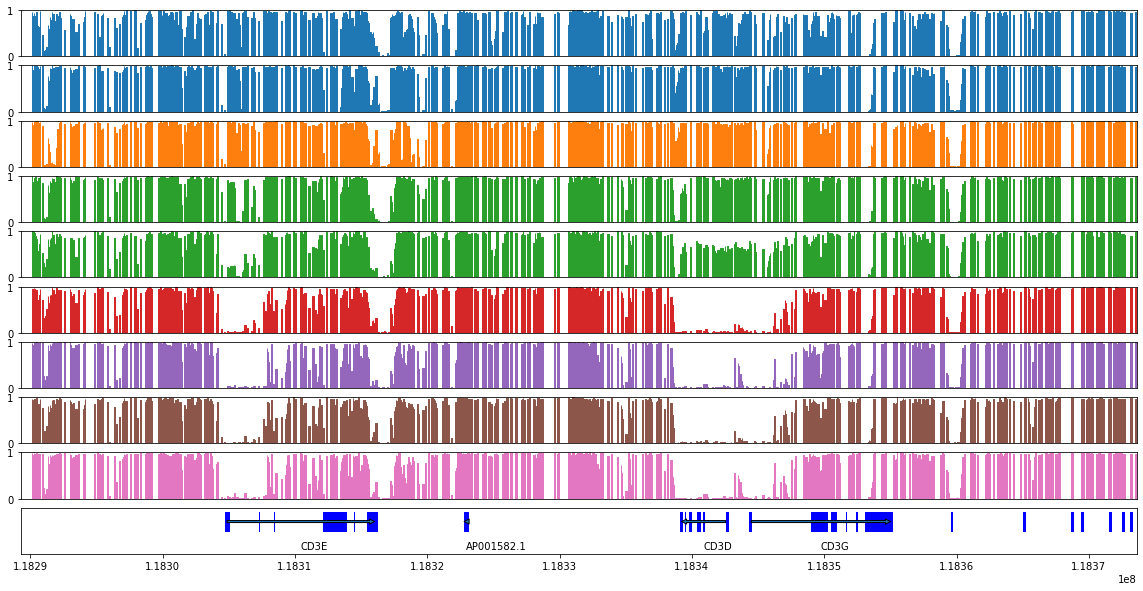

In [21]:
fig, axes = plt.subplots(len(bigwigs)+1,1, figsize=(20, len(bigwigs)+1), sharex=True)
for i, bigwig in enumerate(bigwigs):
    cell = re.sub("\.\S+", "", os.path.basename(bigwig))
    if cell == 'Other-cell':
        continue
    draw_bigwig(axes[i], bigwig, chrom, start, end, cell2color[cell], bins)
draw_gene(axes[i+1], gff_file, chrom, start, end)
plt.savefig("CD3.bigwig.pdf")

In [57]:
bigwig

'/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Th-Naive.CGN-both.frac.bw'

In [22]:
bigwigs

['/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/B-Mem.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/B-Naive.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Monocyte.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/NK-cell1.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/NK-cell2.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Tc-Mem.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Tc-Naive.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Th-Mem.CGN-both.frac.bw',
 '/gale/netapp/DoD/wenliang/projects/07.Ctrl/02.mergeAllc/bigwig/Th-Naive.CGN-both.frac.bw']